# Evaluation

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
projDir = "/content/drive/MyDrive/Spring 2025/Embedded AI/Project/"

# Word Error Rate

In [ ]:
!pip install webvtt-py

In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.0 MB/s eta 0:00:00


In [ ]:
import webvtt
import jiwer
import pickle

In [ ]:
from jiwer import wer

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
def extract_vtt_text(file_path):
    full_text = " ".join([caption.text.replace('\n', ' ') for caption in webvtt.read(file_path)])
    return full_text

In [ ]:
# Load the ground truth texts
conv1_groundtruth_path = projDir + "subtitles/conv1.vtt"
conv2_groundtruth_path = projDir + "subtitles/conv2.vtt"

conv1_groundtruth = extract_vtt_text(conv1_groundtruth_path) # Human annotation
conv2_groundtruth = extract_vtt_text(conv2_groundtruth_path) # YouTube annotation (automatic)

In [ ]:
# Load the mixture text
with open(projDir + 'transcripts/Conv_mix_real_recording.pkl', 'rb') as f:
    result = pickle.load(f)
    conv_mix = result['text']

In [ ]:
# Load the beamformed text for Conv1, Conv2
with open(projDir + 'transcripts/Conv1_real_recording.pkl', 'rb') as f:
    result1 = pickle.load(f)
    conv1_beamformed = result1['text']

with open(projDir + 'transcripts/Conv2_real_recording.pkl', 'rb') as f:
    result2 = pickle.load(f)
    conv2_beamformed = result2['text']

In [ ]:
# Load the Whisper Version
with open(projDir + 'transcripts/Conv1.pkl', 'rb') as f:
    result1 = pickle.load(f)
    conv1_whisper = result1['text']

with open(projDir + 'transcripts/Conv2.pkl', 'rb') as f:
    result2 = pickle.load(f)
    conv2_whisper = result2['text']

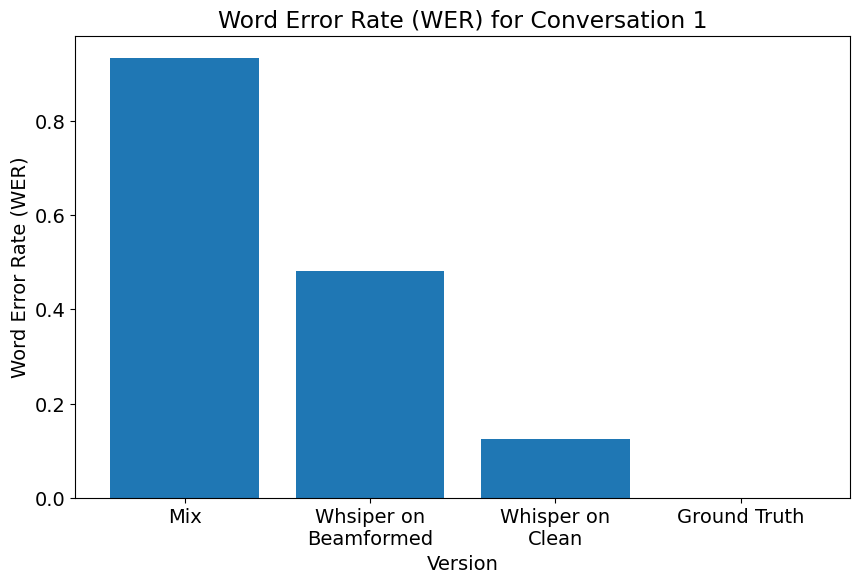

In [ ]:
# Calculate WER for {mix, beamformed, whisper} version using {groundtruth} as reference for Conv1 and plot
wer_mix = wer(conv1_groundtruth.strip().lower(), conv_mix.strip().lower())
wer_beamformed = wer(conv1_groundtruth.strip().lower(), conv1_beamformed.strip().lower())
wer_whisper = wer(conv1_groundtruth.strip().lower(), conv1_whisper.strip().lower())


plt.figure(figsize=(10, 6))
plt.bar(['Mix', 'Whsiper on\nBeamformed', 'Whisper on\nClean', 'Ground Truth'], [wer_mix, wer_beamformed, wer_whisper, 0])
plt.xlabel('Version')
plt.ylabel('Word Error Rate (WER)')
plt.title('Word Error Rate (WER) for Conversation 1')
# Rotate xticklabels
plt.xticks(rotation=0)
# Increase font size
plt.rcParams.update({'font.size': 14})
plt.show()

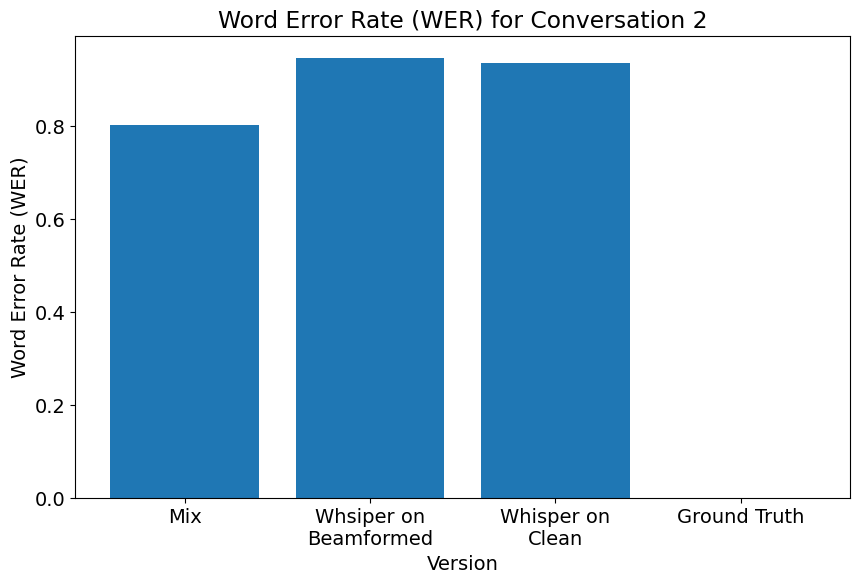

In [ ]:
# Calculate WER for {mix, beamformed, whisper} version using {groundtruth} as reference for Conv2 and plot
wer_mix = wer(conv2_groundtruth.strip().lower(), conv_mix.strip().lower())
wer_beamformed = wer(conv2_groundtruth.strip().lower(), conv1_beamformed.strip().lower())
wer_whisper = wer(conv2_groundtruth.strip().lower(), conv1_whisper.strip().lower())


plt.figure(figsize=(10, 6))
plt.bar(['Mix', 'Whsiper on\nBeamformed', 'Whisper on\nClean', 'Ground Truth'], [wer_mix, wer_beamformed, wer_whisper, 0])
plt.xlabel('Version')
plt.ylabel('Word Error Rate (WER)')
plt.title('Word Error Rate (WER) for Conversation 2')
# Rotate xticklabels
plt.xticks(rotation=0)
# Increase font size
plt.rcParams.update({'font.size': 14})
plt.show()

# Speech Metrics (PESQ, STOI)




In [ ]:
!pip install pesq
!pip install pystoi

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=274955 sha256=071293012580dd0e52a450388dbcb7b4392711fb6fc1beee6e3e4a7c6d6f673b
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq


In [ ]:
from pesq import pesq
from pystoi import stoi

In [ ]:
from scipy.signal import hilbert
from scipy.signal import butter, filtfilt

In [ ]:
import torchaudio

In [ ]:
import librosa
import math
import numpy as np

In [ ]:
TARGET_SR = 8000

In [ ]:
def load_audio(path):
    audio, sr = librosa.load(path, sr=TARGET_SR)
    return audio, sr

def compute_envelope(signal, sr=TARGET_SR, cutoff=12.0):
    """
    Compute the amplitude envelope of a signal using low-pass filtering
    of the rectified waveform.
    """
    # Rectify
    rectified = np.abs(signal)

    # Design low-pass filter (Butterworth, 4th order)
    nyquist = 0.5 * sr
    norm_cutoff = cutoff / nyquist
    b, a = butter(N=4, Wn=norm_cutoff, btype='low')

    # Apply filter
    envelope = filtfilt(b, a, rectified)

    return envelope


def time_align_envelope(ref, est, sr=TARGET_SR, max_duration=10):
    """
    Time-align 'est' to 'ref' using cross-correlation of their envelopes
    computed from only the first `max_duration` seconds.
    """
    # Limit to first `max_duration` seconds
    max_samples = int(sr * max_duration)
    ref_trimmed = ref[:max_samples]
    est_trimmed = est[:max_samples]

    # Compute envelopes
    ref_env = compute_envelope(ref_trimmed)
    est_env = compute_envelope(est_trimmed)

    # Cross-correlation to estimate delay
    corr = np.correlate(ref_env, est_env, mode='full')
    delay = corr.argmax() - len(est_env) + 1

    # Apply estimated delay to full-length signal
    if delay > 0:
        est_aligned = np.pad(est, (delay, 0), 'constant')[:len(ref)]
    else:
        est_aligned = est[-delay:len(ref)-delay] if -delay < len(est) else np.zeros_like(ref)

    return est_aligned, delay

def apply_delay(signal, delay_samples):
    """
    Applies a time shift (delay or advance) to a waveform.

    Args:
        signal (np.ndarray): 1D audio signal.
        delay_samples (int): Positive = delay (pad front), Negative = advance (trim front).

    Returns:
        np.ndarray: Time-shifted signal, same length as input.
    """
    signal = np.asarray(signal)
    N = len(signal)

    if delay_samples > 0:
        # Delay: pad at the start
        shifted = np.pad(signal, (delay_samples, 0), mode='constant')[:N]
    elif delay_samples < 0:
        # Advance: remove samples from start, pad at end
        shifted = signal[-delay_samples:]  # Remove |delay_samples| from start
        shifted = np.pad(shifted, (0, max(0, N - len(shifted))), mode='constant')
    else:
        # No shift
        shifted = signal

    return shifted

In [ ]:
path_ref_conv1 = projDir + "audio/Conv1_mono.wav"
path_ref_conv2 = projDir + "audio/Conv2_mono.wav"

path_mix_conv = projDir + "real_recordings/FullTest_Crop.wav"

path_beamformed_conv1 = projDir + "real_recordings/FullTest_Sep_Conv1_Crop.wav"
path_beamformed_conv2 = projDir + "real_recordings/FullTest_Sep_Conv2_Crop.wav"

In [ ]:
ref1 = load_audio(path_ref_conv1)[0]
ref2 = load_audio(path_ref_conv2)[0]

mix = load_audio(path_mix_conv)[0]

beamformed1 = load_audio(path_beamformed_conv1)[0]
beamformed2 = load_audio(path_beamformed_conv2)[0]

In [ ]:
beamformed1.shape

(29152001,)

In [ ]:
# Align waveforms
beamformed2_aligned, delay2 = time_align_envelope(ref2, beamformed2) # Reliable since conv2 starts with speech whereas conv1 starts with music
beamformed1_aligned = apply_delay(beamformed1, delay2)

mix_aligned = apply_delay(mix, delay2)

In [ ]:
delay2

np.int64(-814)

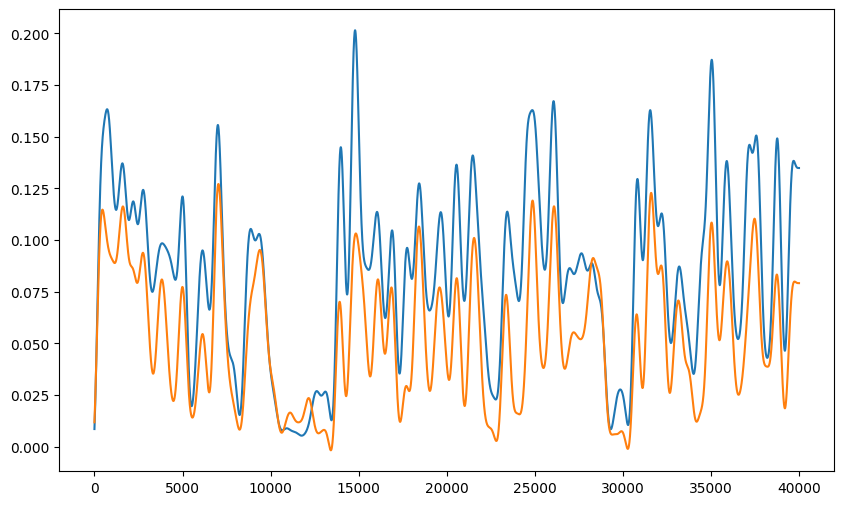

In [ ]:
# Overlay the first second
fig = plt.figure(figsize=(10, 6))
lim = math.ceil(TARGET_SR*5)
plt.plot(compute_envelope(ref2[:lim]), label='Reference')
plt.plot(compute_envelope(beamformed2_aligned[:lim]), label='Beamformed')
plt.show()

In [ ]:
import soundfile as sf

In [ ]:
# Write out the aligned versions
sf.write(projDir + 'real_recordings_8kHz/ref1.wav', ref1, TARGET_SR)
sf.write(projDir + 'real_recordings_8kHz/ref2.wav', ref2, TARGET_SR)
sf.write(projDir + 'real_recordings_8kHz/mix.wav', mix_aligned, TARGET_SR)
sf.write(projDir + 'real_recordings_8kHz/beamformed1.wav', beamformed1_aligned, TARGET_SR)
sf.write(projDir + 'real_recordings_8kHz/beamformed2.wav', beamformed2_aligned, TARGET_SR)

In [ ]:
# Extract out a random 5 s sample form 1200 s
ref1 = ref1[1200*TARGET_SR:1205*TARGET_SR]
ref2 = ref2[1200*TARGET_SR:1205*TARGET_SR]
mix_aligned = mix_aligned[1200*TARGET_SR:1205*TARGET_SR]
beamformed1_aligned = beamformed1_aligned[1200*TARGET_SR:1205*TARGET_SR]
beamformed2_aligned = beamformed2_aligned[1200*TARGET_SR:1205*TARGET_SR]

In [ ]:
# Write out these clips

sf.write(projDir + 'real_recordings_8kHz/ref1_short.wav', ref1, TARGET_SR)
sf.write(projDir + 'real_recordings_8kHz/ref2_short.wav', ref2, TARGET_SR)
sf.write(projDir + 'real_recordings_8kHz/mix_short.wav', mix_aligned, TARGET_SR)
sf.write(projDir + 'real_recordings_8kHz/beamformed1_short.wav', beamformed1_aligned, TARGET_SR)
sf.write(projDir + 'real_recordings_8kHz/beamformed2_short.wav', beamformed2_aligned, TARGET_SR)

In [ ]:
# Truncate all to same length
# min_len = min(len(ref1), len(ref2), len(mix), len(beamformed1_aligned), len(beamformed2_aligned))
min_len = TARGET_SR * 60
ref1 = ref1[:min_len]
ref2 = ref2[:min_len]
mix_aligned = mix_aligned[:min_len]
beamformed1_aligned = beamformed1_aligned[:min_len]
beamformed2_aligned = beamformed2_aligned[:min_len]

In [ ]:
# Conversation 1

# PESQ (Wideband mode)
pesq_noisy = pesq(TARGET_SR, ref1, mix_aligned, 'nb')
pesq_beamformed = pesq(TARGET_SR, ref1, beamformed1_aligned, 'nb')
pesq_score_improvement = pesq_beamformed - pesq_noisy

In [ ]:
# STOI
stoi_noisy = stoi(ref1, mix_aligned, TARGET_SR, extended=False)
stoi_beamformed = stoi(ref1, beamformed1_aligned, TARGET_SR, extended=False)
stoi_score_improvement = stoi_beamformed - stoi_noisy

In [ ]:
import torch

In [ ]:
# SI-SDR
ref_tensor = torch.tensor(ref1)
mix_tensor = torch.tensor(mix_aligned)
enh_tensor = torch.tensor(beamformed1_aligned)

si_sdr_noisy = 10 * torch.log10(torch.sum(ref_tensor ** 2) / torch.sum((ref_tensor - mix_tensor) ** 2)).item()
si_sdr_beamformed = 10 * torch.log10(torch.sum(ref_tensor ** 2) / torch.sum((ref_tensor - enh_tensor) ** 2)).item()
si_sdr_improvement = si_sdr_beamformed - si_sdr_noisy

In [ ]:
# Print metrics
print("Conversation 1:")
print(f"PESQ (Narrowband mode): Noisy: {pesq_noisy:.2f}, Beamformed: {pesq_beamformed:.2f}, Improvement: {pesq_score_improvement:.2f}")
print(f"STOI: Noisy: {stoi_noisy:.2f}, Beamformed: {stoi_beamformed:.2f}, Improvement: {stoi_score_improvement:.2f}")
print(f"SI-SDR: Noisy: {si_sdr_noisy:.2f}, Beamformed: {si_sdr_beamformed:.2f}, Improvement: {si_sdr_improvement:.2f}")

Conversation 1:
PESQ (Narrowband mode): Noisy: 1.35, Beamformed: 2.50, Improvement: 1.15
STOI: Noisy: 0.23, Beamformed: 0.63, Improvement: 0.41
SI-SDR: Noisy: -1.23, Beamformed: -1.00, Improvement: 0.23


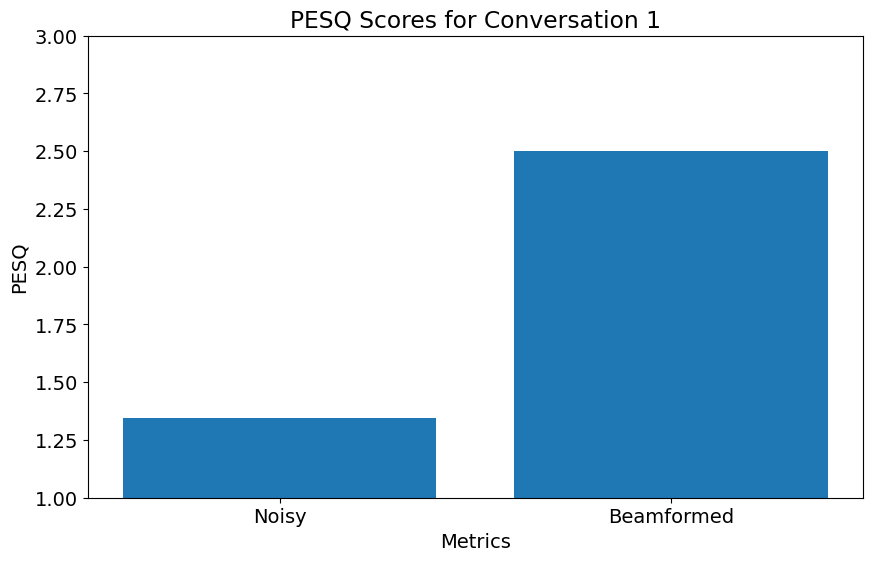

In [ ]:
# Make Barcharts for PESQ
plt.figure(figsize=(10, 6))
plt.bar(['Noisy', 'Beamformed'], [pesq_noisy, pesq_beamformed])
plt.xlabel('Metrics')
plt.ylabel('PESQ')
plt.title('PESQ Scores for Conversation 1')
plt.ylim(1, 3)
# Font size to 14
plt.rcParams.update({'font.size': 14})
plt.show()

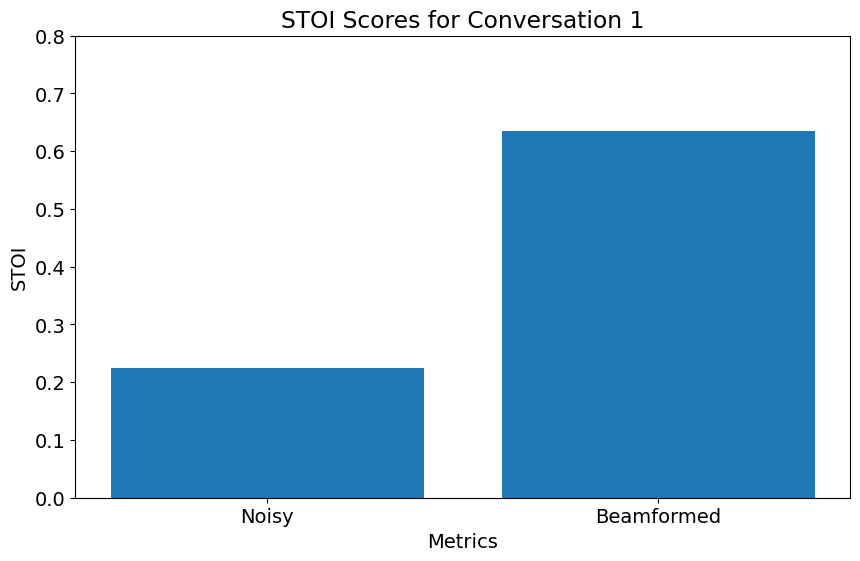

In [ ]:
# Make Barcharts for STOI
plt.figure(figsize=(10, 6))
plt.bar(['Noisy', 'Beamformed'], [stoi_noisy, stoi_beamformed])
plt.xlabel('Metrics')
plt.ylabel('STOI')
plt.title('STOI Scores for Conversation 1')
plt.ylim(0, 0.8)
# Font size to 14
plt.rcParams.update({'font.size': 14})
plt.show()

In [ ]:
# Conversation 2

# PESQ (Wideband mode)
pesq_noisy = pesq(TARGET_SR, ref2, mix_aligned, 'nb')
pesq_beamformed = pesq(TARGET_SR, ref2, beamformed2_aligned, 'nb')
pesq_score_improvement = pesq_beamformed - pesq_noisy

In [ ]:
# STOI
stoi_noisy = stoi(ref2, mix_aligned, TARGET_SR, extended=False)
stoi_beamformed = stoi(ref2, beamformed2_aligned, TARGET_SR, extended=False)
stoi_score_improvement = stoi_beamformed - stoi_noisy

In [ ]:
# SI-SDR
ref_tensor = torch.tensor(ref2)
mix_tensor = torch.tensor(mix_aligned)
enh_tensor = torch.tensor(beamformed2_aligned)

si_sdr_noisy = 10 * torch.log10(torch.sum(ref_tensor ** 2) / torch.sum((ref_tensor - mix_tensor) ** 2)).item()
si_sdr_beamformed = 10 * torch.log10(torch.sum(ref_tensor ** 2) / torch.sum((ref_tensor - enh_tensor) ** 2)).item()
si_sdr_improvement = si_sdr_beamformed - si_sdr_noisy

In [ ]:
# Print metrics
print("Conversation 2:")
print(f"PESQ (Narrowband mode): Noisy: {pesq_noisy:.2f}, Beamformed: {pesq_beamformed:.2f}, Improvement: {pesq_score_improvement:.2f}")
print(f"STOI: Noisy: {stoi_noisy:.2f}, Beamformed: {stoi_beamformed:.2f}, Improvement: {stoi_score_improvement:.2f}")
print(f"SI-SDR: Noisy: {si_sdr_noisy:.2f}, Beamformed: {si_sdr_beamformed:.2f}, Improvement: {si_sdr_improvement:.2f}")

Conversation 2:
PESQ (Narrowband mode): Noisy: 1.46, Beamformed: 2.35, Improvement: 0.88
STOI: Noisy: 0.33, Beamformed: 0.70, Improvement: 0.38
SI-SDR: Noisy: -1.79, Beamformed: -1.53, Improvement: 0.25


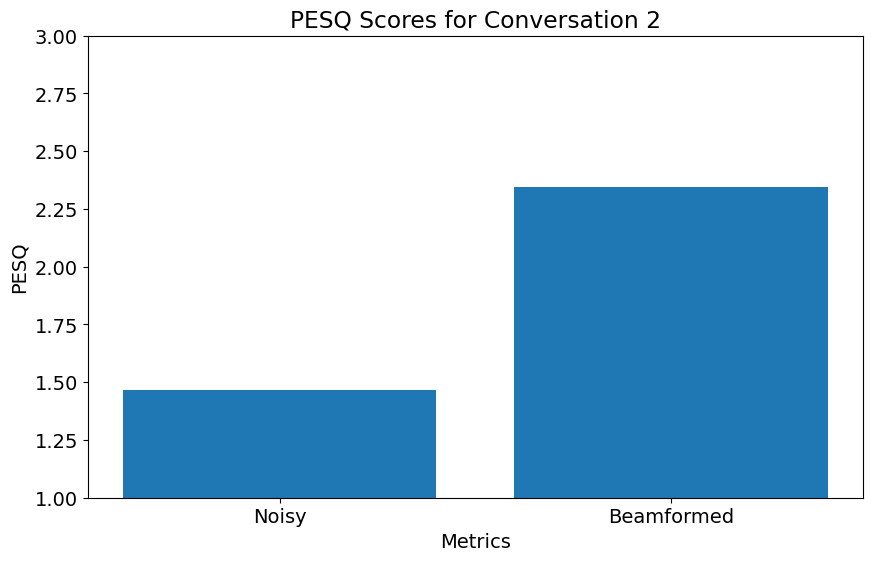

In [ ]:
# Make Barcharts for PESQ
plt.figure(figsize=(10, 6))
plt.bar(['Noisy', 'Beamformed'], [pesq_noisy, pesq_beamformed])
plt.xlabel('Metrics')
plt.ylabel('PESQ')
plt.title('PESQ Scores for Conversation 2')
plt.ylim(1, 3)
# Font size to 14
plt.rcParams.update({'font.size': 14})
plt.show()

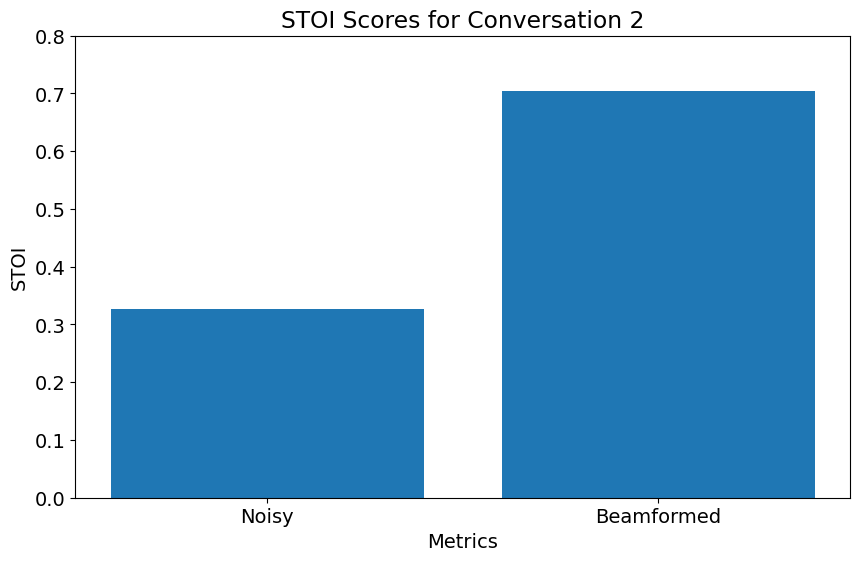

In [ ]:
# Make Barcharts for STOI
plt.figure(figsize=(10, 6))
plt.bar(['Noisy', 'Beamformed'], [stoi_noisy, stoi_beamformed])
plt.xlabel('Metrics')
plt.ylabel('STOI')
plt.title('STOI Scores for Conversation 2')
plt.ylim(0, 0.8)
# Font size to 14
plt.rcParams.update({'font.size': 14})
plt.show()